# DehazeNet

In [ ]:
#/content

In [ ]:
!wget -q http://www.vision.ee.ethz.ch/ntire18/o-haze/O-HAZE.zip

In [2]:
!unzip -q O-HAZE.zip 
import os
os.rename("# O-HAZY NTIRE 2018","ohaze")

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
BATCH_SIZE = 128
EPOCH = 10


In [4]:

class DehazeNet(Model):
  def __init__(self, inputs=16, groups=4):
    super(DehazeNet, self).__init__()
    self.inputs = inputs
    self.groups = groups
    self.conv1=tf.keras.layers.Conv2D(16,kernel_size=5)
    self.conv2=tf.keras.layers.Conv2D(16,kernel_size=3,padding='SAME')
    self.conv3=tf.keras.layers.Conv2D(16,kernel_size=5,padding='SAME')
    self.conv4=tf.keras.layers.Conv2D(16,kernel_size=7,padding='SAME')
    self.maxpool=tf.keras.layers.MaxPool2D(7,1)
    self.conv5=tf.keras.layers.Conv2D(1,kernel_size=6)
    self.brelu=tf.keras.activations.relu

  def Maxout(self,x,groups):
    x = x.reshape(x.shape[0], groups, x.shape[1]//groups, x.shape[2], x.shape[3])
    x, y = np.max(x, dim=2, keepdim=True)
    out = x.reshape(x.shape[0],-1, x.shape[3], x.shape[4])
    return out

  def call(self, x):
    out = self.conv1(x)
    out = self.Maxout(out, self.groups)
    out1 = self.conv2(out)
    out2 = self.conv3(out)
    out3 = self.conv4(out)
    y = tf.concat((out1,out2,out3), dim=1)
		#print(y.shape[0],y.shape[1],y.shape[2],y.shape[3],)
    y = self.maxpool(y)
		#print(y.shape[0],y.shape[1],y.shape[2],y.shape[3],)
    y = self.conv5(y)
		# y = self.relu(y)
		# y = self.BRelu(y)
		#y = torch.min(y, torch.ones(y.shape[0],y.shape[1],y.shape[2],y.shape[3]))
    y = self.brelu(y)
    y = y.reshape(y.shape[0],-1)
    return y

In [5]:
model=DehazeNet()

In [6]:
model.build(input_shape=(10, 480, 480, 3))
#model.summary()

In [7]:
def data_path(orig_img_path, hazy_img_path):
    
    train_img = []
    val_img = []
    
    #orig_img = glob.glob(orig_img_path + '\*.jpg')        
    #hazy_img = glob.glob(hazy_img_path + '\*.jpg')
    orig_img = glob.glob('./ohaze/GT/*.jpg')        
    hazy_img = glob.glob('./ohaze/hazy/*.jpg')
    for x in range(len(orig_img)):
        if (x < 0.8*len(orig_img)):
            train_img.append([hazy_img[x], orig_img[x]])
        else:
            val_img.append([hazy_img[x], orig_img[x]])
            
    return train_img, val_img

In [8]:
epochs = 1
batch_size = 3
orig_path='./ohaze/GT';
hazy_path='./ohaze/hazy';
train_data, val_data = data_path(orig_path,hazy_path)



In [ ]:
import cv2
def display_img(path):
   img = cv2.imread(path,cv2.IMREAD_COLOR)
   plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

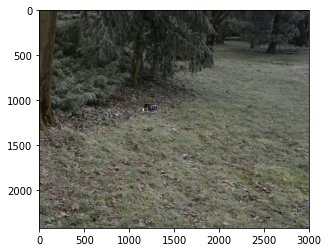

In [ ]:
def dataloader(train_data, val_data, batch_size):
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(100).batch(batch_size)
    
    return train, val

In [ ]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (550, 413), antialias = True)
    img = img / 255.0
    return img
train, val = dataloader(train_data, val_data, batch_size)

In [ ]:
train

<BatchDataset shapes: ((None, 550, 413, 3), (None, 550, 413, 3)), types: (tf.float32, tf.float32)>

Model: "dehaze_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


ValueError: ignored

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

## testing

In [12]:

!wget  http://www.vision.ee.ethz.ch/ntire18/o-haze/O-HAZE.zip
!unzip -q O-HAZE.zip 

--2021-02-12 14:35:12--  http://www.vision.ee.ethz.ch/ntire18/o-haze/O-HAZE.zip
Resolving www.vision.ee.ethz.ch (www.vision.ee.ethz.ch)... 129.132.19.216, 2001:67c:10ec:254::216
Connecting to www.vision.ee.ethz.ch (www.vision.ee.ethz.ch)|129.132.19.216|:80... connected.
HTTP request sent, awaiting response... 301 
Location: https://data.vision.ee.ethz.ch/cvl/ntire18//o-haze/O-HAZE.zip [following]
--2021-02-12 14:35:12--  https://data.vision.ee.ethz.ch/cvl/ntire18//o-haze/O-HAZE.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 573320339 (547M) [application/zip]
Saving to: ‘O-HAZE.zip.1’

O-HAZE.zip.1        100%[===================>] 546.76M  26.5MB/s    in 22s     

2021-02-12 14:35:34 (25.1 MB/s) - ‘O-HAZE.zip.1’ saved [573320339/573320339]



In [9]:
#!/usr/bin/env python
# coding: utf-8

# In

import os
os.rename("# O-HAZY NTIRE 2018","ohaze")
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (550, 413), antialias = True)
    img = img / 255.0
    return img


In [10]:
#!/usr/bin/env python
# coding: utf-8

# In[4]:


def dataloader(orig_img_path, hazy_img_path, batch_size, test_to_val_ratio):
    
    # test_to_val_ratio : value between 0 to 1....eg. 0.9
    
    train_data = []
    val_data = []
    
    orig_img = glob.glob(orig_img_path + '\*.jpg')        
    hazy_img = glob.glob(hazy_img_path + '\*.jpg')
    n = len(orig_img)
    
    for x in range(n):
        if (x < int(test_to_val_ratio*n)):
            train_data.append([hazy_img[x], orig_img[x]])
        else:
            val_data.append([hazy_img[x], orig_img[x]])
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))    
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(100).batch(batch_size)
    for images in train:
        print(images)

    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(100).batch(batch_size)
    for images in val:
        print(images)

    
    return train, val


# In[ ]:





In [11]:
dataloader('./ohaze/GT/*.jpg','./ohaze/hazy/*.jpg',40,0.8)

TypeError: ignored